In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
np.random.seed(51)  

delta_rel = np.array([0.001, 0.001, 0.0005, 0.001])  # δx1=0.1%, δx2=0.1%, δx3=0.05%, δx4=0.1%
k = 0.01  # коэффициент преобразования предела погрешности

### Исходные данные

In [7]:
def f(x1, x2, x3, x4):
    return x1/x2**2 + x2/x3**2 + x4/x1**2

datasets = [
    # Набор 1
    {
        "x": np.array([1.0, 2.0, 3.0, 4.0]),
        "delta_rel": delta_rel,
        "name": "Набор 1"
    },
    # Набор 2
    {
        "x": np.array([2.0, 1.5, 2.5, 3.5]),
        "delta_rel": delta_rel,
        "name": "Набор 2"
    },
    # Набор 3 
    {
        "x": np.array([1.2, 2.2, 3.1, 3.9]),
        "delta_rel": delta_rel,
        "name": "Набор 3"
    }
]

print("Параметры для всех наборов:")
print("δx1 = 0.1%, δx2 = 0.1%, δx3 = 0.05%, δx4 = 0.1%")
print("k =", k)

Параметры для всех наборов:
δx1 = 0.1%, δx2 = 0.1%, δx3 = 0.05%, δx4 = 0.1%
k = 0.01


### Расчет Δy для трех наборов

In [ ]:
for idx, data in enumerate(datasets):
    print(f"{data['name']}: x = {data['x']}")
    
    x = data["x"]
    delta_rel = data["delta_rel"]
    delta_x = delta_rel * x  # Абсолютные погрешности
    
    # 1. Метод Монте-Карло (N = 10^6)
    N_mc = 10**6
    # Генерация случайных значений из равномерного распределения
    xj_mc = np.array([
        np.random.uniform(x[i] - delta_x[i], x[i] + delta_x[i], N_mc) 
        for i in range(4)
    ])
    yj_mc = f(*xj_mc)  # Вычисление значений функции
    y0 = f(*x)  # Номинальное значение
    Delta_y_mc = np.max(np.abs(yj_mc - y0))
    
    # 2. Метод Крейновича (N = 300)
    N_krey = 300
    d_i = k * delta_x  # Параметры масштаба для распределения Коши
    
    # Генерация случайных значений из распределения Коши
    xj_k = np.array([
        np.random.standard_cauchy(size=N_krey) * d_i[i] + x[i] 
        for i in range(4)
    ])
    yj_k = f(*xj_k)
    dy_k = yj_k - y0
    
    # Функция для оценки параметра масштаба d методом максимального правдоподобия
    def equation_for_d(d, dy):
        """Уравнение для оценки параметра масштаба распределения Коши"""
        return np.sum(d**2 / (dy**2 + d**2)) - len(dy)/2
    
    # Решение уравнения
    d_hat, = fsolve(equation_for_d, 0.001, args=(dy_k,))
    Delta_y_krey = np.abs(d_hat) / k
    
    print(f"  Метод Монте-Карло (N={N_mc}): Δy = {Delta_y_mc:.6f}")
    print(f"  Метод Крейновича (N={N_krey}): Δy = {Delta_y_krey:.6f}")
    print(f"  Относительное расхождение: {abs(Delta_y_mc - Delta_y_krey)/Delta_y_mc*100:.2f}%")

Δy для трех наборов входных данных:

Набор 1: x = [1. 2. 3. 4.]
  Метод Монте-Карло (N=1000000): Δy = 0.012123
  Метод Крейновича (N=300): Δy = 0.012514
  Относительное расхождение: 3.23%
Набор 2: x = [2.  1.5 2.5 3.5]
  Метод Монте-Карло (N=1000000): Δy = 0.003441
  Метод Крейновича (N=300): Δy = 0.003242
  Относительное расхождение: 5.80%
Набор 3: x = [1.2 2.2 3.1 3.9]
  Метод Монте-Карло (N=1000000): Δy = 0.008235
  Метод Крейновича (N=300): Δy = 0.008041
  Относительное расхождение: 2.36%


### Исследование зависимости Δy от N для набора 3 (3 повтора)

In [ ]:
# Используем набор 3
data = datasets[2]
x = data["x"]
delta_rel = data["delta_rel"]
delta_x = delta_rel * x
d_i = k * delta_x
y0 = f(*x)

# Список значений N для исследования
N_list = [10**1, 10**2, 200, 300, 500, 10**3, 10**4, 10**5]
lg_N_list = np.log10(N_list)

# Результаты для трех повторов
MC_all_results = []  # Для метода Монте-Карло
Krey_all_results = []  # Для метода Крейновича

for repeat in range(3):
    print(f"\nПОВТОР {repeat+1}")
    print(f"Параметры: x = {x}, y0 = {y0:.4f}")
    print("N\tMC Δy\t\tKrey Δy\t\tРазница")
    
    MC_results = []
    Krey_results = []
    
    for N in N_list:
        # Метод Монте-Карло
        xj_mc = np.array([
            np.random.uniform(x[i] - delta_x[i], x[i] + delta_x[i], N)
            for i in range(4)
        ])
        yj_mc = f(*xj_mc)
        Delta_mc = np.max(np.abs(yj_mc - y0))
        MC_results.append(Delta_mc)
        
        # Метод Крейновича
        xj_k = np.array([
            np.random.standard_cauchy(size=N) * d_i[i] + x[i]
            for i in range(4)
        ])
        yj_k = f(*xj_k)
        dy_k = yj_k - y0
        
        # Решение уравнения для оценки d
        d_hat, = fsolve(equation_for_d, 0.001, args=(dy_k,))
        Delta_k = np.abs(d_hat) / k
        Krey_results.append(Delta_k)
        
        # Вывод результатов для текущего N
        diff = abs(Delta_mc - Delta_k)
        print(f"{N}\t{Delta_mc:.6f}\t{Delta_k:.6f}\t{diff:.6f}")
    
    MC_all_results.append(MC_results)
    Krey_all_results.append(Krey_results)

Исследование зависимости Δy от объема выборки N (3 повтора для Набора 3)

ПОВТОР 1
Параметры: x = [1.2 2.2 3.1 3.9], y0 = 3.1852
N	MC Δy		Krey Δy		Разница
10	0.005426	0.008240	0.002813
100	0.007546	0.009686	0.002140
200	0.007736	0.008649	0.000913
300	0.007847	0.008643	0.000797
500	0.007657	0.008459	0.000803
1000	0.007820	0.008466	0.000646
10000	0.008001	0.008161	0.000160
100000	0.008169	0.008359	0.000190

ПОВТОР 2
Параметры: x = [1.2 2.2 3.1 3.9], y0 = 3.1852
N	MC Δy		Krey Δy		Разница
10	0.005066	0.011449	0.006383
100	0.007135	0.008777	0.001642
200	0.007563	0.008108	0.000545
300	0.007451	0.008348	0.000897
500	0.007851	0.008544	0.000693
1000	0.007780	0.008067	0.000287
10000	0.008129	0.008452	0.000323
100000	0.008160	0.008334	0.000174

ПОВТОР 3
Параметры: x = [1.2 2.2 3.1 3.9], y0 = 3.1852
N	MC Δy		Krey Δy		Разница
10	0.004318	0.004866	0.000548
100	0.007455	0.007594	0.000140
200	0.007328	0.009133	0.001805
300	0.007755	0.008356	0.000601
500	0.007523	0.008468	0.000944
1000	0.007629	0.00806

### Построение графиков

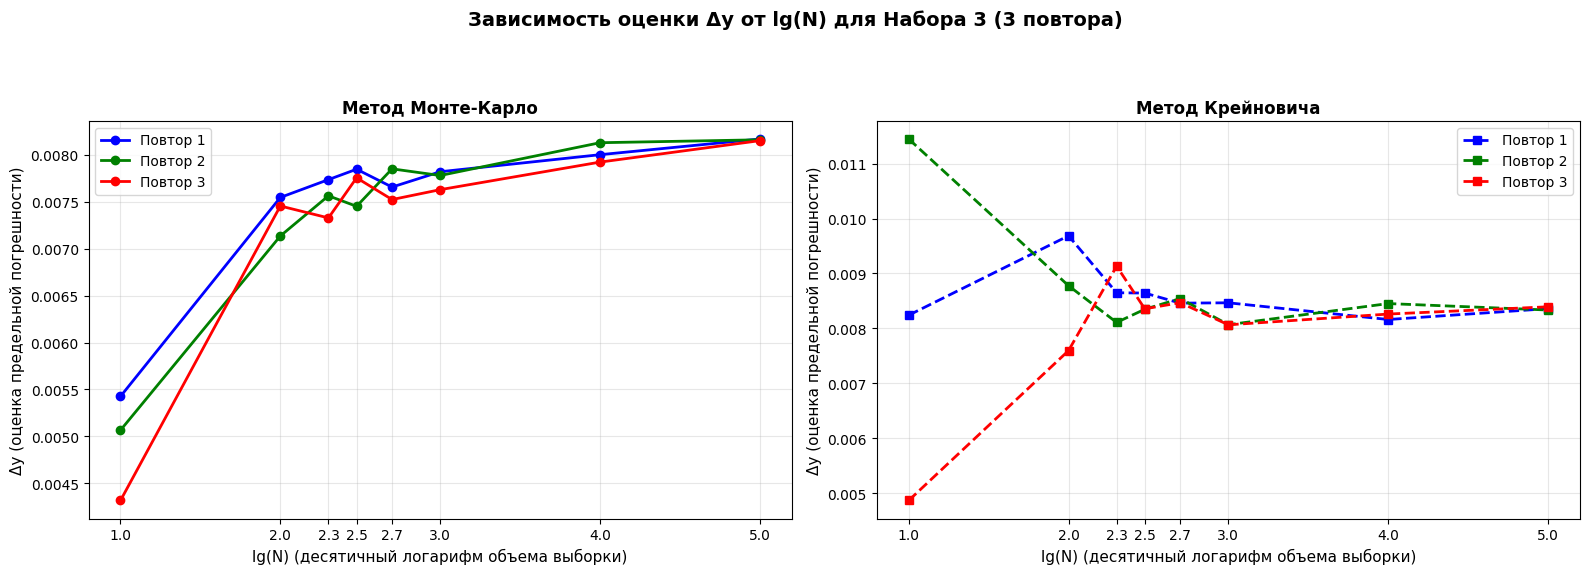

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Зависимость оценки Δy от lg(N) для Набора 3 (3 повтора)\n", fontsize=14, fontweight='bold')

# Цвета для разных повторов
colors = ['blue', 'green', 'red']

# График для метода Монте-Карло
axes[0].set_title("Метод Монте-Карло", fontsize=12, fontweight='bold')
for repeat in range(3):
    axes[0].plot(lg_N_list, MC_all_results[repeat], 
                 marker="o", linestyle='-', 
                 color=colors[repeat], 
                 linewidth=2, markersize=6,
                 label=f"Повтор {repeat+1}")

axes[0].set_xlabel("lg(N) (десятичный логарифм объема выборки)", fontsize=11)
axes[0].set_ylabel("Δy (оценка предельной погрешности)", fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)
axes[0].set_xticks(lg_N_list)
axes[0].set_xticklabels([f'{val:.1f}' for val in lg_N_list])

# График для метода Крейновича
axes[1].set_title("Метод Крейновича", fontsize=12, fontweight='bold')
for repeat in range(3):
    axes[1].plot(lg_N_list, Krey_all_results[repeat], 
                 marker="s", linestyle='--', 
                 color=colors[repeat], 
                 linewidth=2, markersize=6,
                 label=f"Повтор {repeat+1}")

axes[1].set_xlabel("lg(N) (десятичный логарифм объема выборки)", fontsize=11)
axes[1].set_ylabel("Δy (оценка предельной погрешности)", fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)
axes[1].set_xticks(lg_N_list)
axes[1].set_xticklabels([f'{val:.1f}' for val in lg_N_list])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()